In this notebook, we use NQFS to study the ground state of the quadatic Hamiltonian, which is equivalent to a regularized Klein-Gordon model:

\begin{equation}
H_{\text{Quad}} = \int dx \frac{d\hat{\psi}^\dagger(x)}{dx} \frac{d \hat{\psi} (x)}{dx} 
+ v\int dx \ \hat{\psi}^\dagger(x) \hat{\psi} (x) 
+ \lambda \int dx \ \big(\hat{\psi} (x) \hat{\psi} (x) +  \hat{\psi}^\dagger(x)\hat{\psi}^\dagger(x) \big).
\end{equation}


In [2]:
# Allow to import packages from NQFS Repo on Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Allow to import classes from ./modules
import sys
sys.path.insert(1, '/content/drive/My Drive/Research/NQFS Repo/modules')    # Set this directory to wherever the /modules folder is stored

Mounted at /content/drive


In [3]:
# Import packages
import numpy as np
import itertools
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.special import gammaln, factorial

# from deep_sets import Deep_Sets
from nqfs_quad import NQFS_Quad

In [4]:
# NQFS parameters
DS_width = 100        # Width of the neural networks in the deep sets NQFS
DS_depth_phi = 3      # Depth of the phi neural network in the deep sets NQFS
DS_depth_rho = 3      # Depth of the rho neural network in the deep sets NQFS
L = 1                 # System length 
periodic = True       # System periodicity

# Creates NQFS for the quadratic model
myNQFS = NQFS_Quad(DS_width, DS_depth_phi, DS_depth_rho, L, periodic)

# Initializes GPU, moves NQFS to GPU
GPU_device = torch.device("cuda:0")
myNQFS.DS1.to(GPU_device)
myNQFS.DS2.to(GPU_device)
torch.set_default_dtype(torch.float32)

In [5]:
# Hamiltonian parameters
v = 6                    # coefficient of particle number term
lam = -0.4*v             # coefficient of (psi(x)*psi(x) + h.c.)

# Exact energy of the quadratic model   
N_max = 2000              # Maximum integer over which the sum extends in ground state energy density computation
epsilon_exact = myNQFS.Exact_energy_density_Quad(v, lam, L, N_max)
E_exact = L*epsilon_exact
print('E_exact: ' + str(E_exact))

E_exact: -1.6385442436031552


In [6]:
# MCMC parameters
n_samples = 800       # Number of samples per MCMC chain
n_chains = 100        # Number of independent MCMC chains
p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal

N_int = 50
batch_size = 500

# Minimization parameters
beta_1 = 0.9          # ADAM parameter      
beta_2 = 0.999        # ADAM parameter
lr = 1e-3             # Learning rate
lr_q = 1e-2           # Learning rate for q_n
n_iters = 300         # Number of ADAM iterations to be performed

# Minimizes energy
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, v, lam, 
                              beta_1, beta_2, lr, lr_q, n_iters, N_int, batch_size)

Iteration: 1/300
Energy: 3.654 +- 0.1
Number of particles: 1.818 +- 1.169


Iteration: 2/300
Energy: 2.654 +- 0.084
Number of particles: 1.636 +- 1.14


Iteration: 3/300
Energy: 2.757 +- 0.082
Number of particles: 1.568 +- 1.141


Iteration: 4/300
Energy: 2.181 +- 0.093
Number of particles: 1.402 +- 1.122


Iteration: 5/300
Energy: 1.734 +- 0.076
Number of particles: 1.261 +- 1.108


Iteration: 6/300
Energy: 1.204 +- 0.081
Number of particles: 1.12 +- 1.103


Iteration: 7/300
Energy: 0.643 +- 0.081
Number of particles: 0.968 +- 1.08


Iteration: 8/300
Energy: -0.026 +- 0.069
Number of particles: 0.791 +- 1.038


Iteration: 9/300
Energy: -0.487 +- 0.083
Number of particles: 0.627 +- 0.971


Iteration: 10/300
Energy: -1.082 +- 0.048
Number of particles: 0.434 +- 0.857


Iteration: 11/300
Energy: -1.188 +- 0.052
Number of particles: 0.317 +- 0.764


Iteration: 12/300
Energy: -1.237 +- 0.053
Number of particles: 0.217 +- 0.657


Iteration: 13/300
Energy: -1.236 +- 0.041
Number of particles

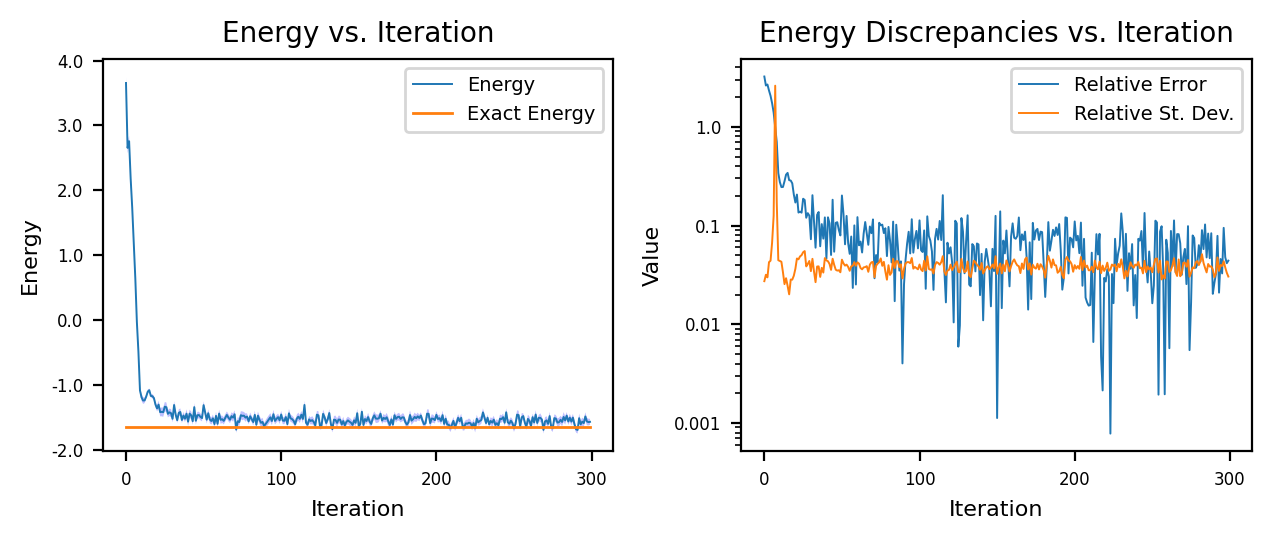

In [8]:
# Plots energy vs iteration
start = 0
end = n_iters
myNQFS.plot_energy(Es, E_stds, E_exact, start, end)

In [12]:
# Use repeated sampling to obtain final estimates of energy and particle number

# MCMC parameters
n_samples = 1000                      # Number of samples per MCMC chain
n_chains = 100                        # Number of independent MCMC chains
p_pm = 0.25                           # Probability of increasing/decreasing particle number in configuration proposal
n_0 =  2*round(n_means[-1].item()/2)  # Initial particle number of each MCMC chain
N_reps = 20
Es_reps = np.zeros(N_reps)
E_stds_reps = np.zeros(N_reps)

# Use repeated sampling to decrease variance of estimates, estimates energy and 
# particle number over N_Reps repetitions
for j in range(N_reps):
  print('Repetition: ' + str(j+1) + '/' + str(N_reps))

  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
    myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, GPU_device)

  # Concatenates particle numbers     
  if j == 0:
    n_total = n[None,:] 
  else:
    n_total = torch.cat((n_total, n[None,:]), dim=0) 
  
  # Estimates energy, concatenates results 
  E, E_std = myNQFS.Energy_Estimate(x_sorted, chain_idx_sorted, n_chains, 
                                    GPU_device, v, lam, N_int, batch_size)   
  Es_reps[j-1] = E.detach().clone()
  E_stds_reps[j-1] = E_std.detach().clone()


# Computes final mean and standard deviation
E_mean_final = np.mean(Es_reps)
E_std_final = (np.mean(E_stds_reps**2)/N_reps)**(0.5)
n_total = n_total.cpu().numpy().astype(float)

print('\n')
print("Energy: " + str(E_mean_final) + " +- " + str(E_std_final))

Repetition: 1/20
Repetition: 2/20
Repetition: 3/20
Repetition: 4/20
Repetition: 5/20
Repetition: 6/20
Repetition: 7/20
Repetition: 8/20
Repetition: 9/20
Repetition: 10/20
Repetition: 11/20
Repetition: 12/20
Repetition: 13/20
Repetition: 14/20
Repetition: 15/20
Repetition: 16/20
Repetition: 17/20
Repetition: 18/20
Repetition: 19/20
Repetition: 20/20


Energy: -1.5521820843219758 +- 0.011275919665257334


In [13]:
# Computes histogram of particle number
total_counts = np.zeros((n_total.shape[0], np.max(n_total.astype(int))//2+1))
for j in range(n_total.shape[0]):
  counts, bins = np.histogram(n_total[j,:], bins = np.arange(0, np.max(n_total) + 2))
  total_counts[j,:] = counts[::2]
total_hists = total_counts/n_total.shape[1]  

# Computes emperical particle number probability distribution
P_n_approx = np.mean(total_hists, axis=0)
P_n_approx_std = np.std(total_hists, axis=0)/(total_hists.shape[0]**0.5)

# Computes exact particle number distribution
N_max = 14
n_max = np.max(n_total.astype(int))
P_n_exact = myNQFS.Exact_P_n(v, lam, L, n_max, N_max)

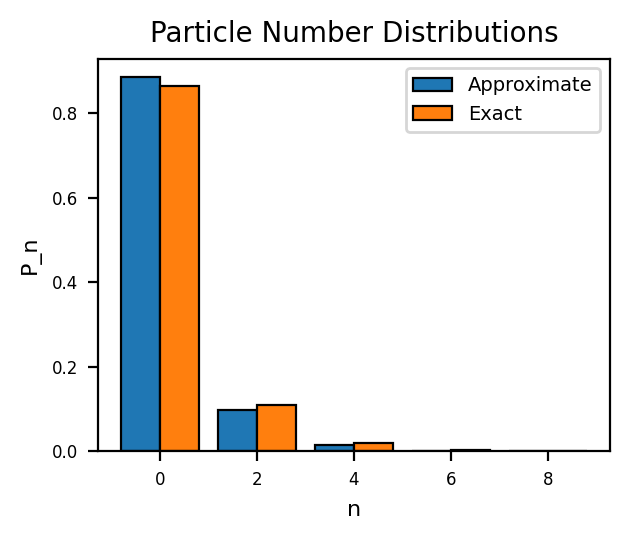

In [14]:
# Plots particle number distributions
myNQFS.plot_P_n(P_n_approx, P_n_exact)